In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[mujoco]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 2s (541 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium import utils
from gymnasium.wrappers import TransformReward, TransformObservation

from gymnasium.envs.mujoco.reacher_v4 import ReacherEnv
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box, Discrete
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import scipy
from scipy.stats import norm
from scipy.special import logsumexp


from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from typing import Tuple

from collections import deque

import pickle

from river import drift

In [3]:
env0 = gym.make("Reacher-v4") ## Training Environment
env1 = gym.make("Reacher-v4") ## undrifted Production Environment

## Create Drifted Environment Class

In [4]:
DEFAULT_CAMERA_CONFIG = {"trackbodyid": 0}

class ReacherEnvDrifted(MujocoEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 50,
    }

    def __init__(self, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)
        observation_space = Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float64)
        MujocoEnv.__init__(
            self,
            "./reacher_drifted.xml",
            2,
            observation_space=observation_space,
            default_camera_config=DEFAULT_CAMERA_CONFIG,
            **kwargs,
        )

    def step(self, a):
        vec = self.get_body_com("fingertip") - self.get_body_com("target")
        reward_dist = -np.linalg.norm(vec)
        reward_ctrl = -np.square(a).sum()
        reward = reward_dist + reward_ctrl

        self.do_simulation(a, self.frame_skip)
        if self.render_mode == "human":
            self.render()

        ob = self._get_obs()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return (
            ob,
            reward,
            False,
            False,
            dict(reward_dist=reward_dist, reward_ctrl=reward_ctrl),
        )

    def reset_model(self):
        qpos = (
            self.np_random.uniform(low=-0.1, high=0.1, size=self.model.nq)
            + self.init_qpos
        )
        while True:
            self.goal = self.np_random.uniform(low=-0.2, high=0.2, size=2)
            if np.linalg.norm(self.goal) < 0.2:
                break
        qpos[-2:] = self.goal
        qvel = self.init_qvel + self.np_random.uniform(
            low=-0.005, high=0.005, size=self.model.nv
        )
        qvel[-2:] = 0
        self.set_state(qpos, qvel)
        return self._get_obs()

    def _get_obs(self):
        theta = self.data.qpos.flat[:2]
        return np.concatenate(
            [
                np.cos(theta),
                np.sin(theta),
                self.data.qpos.flat[2:],
                self.data.qvel.flat[:2],
                self.get_body_com("fingertip") - self.get_body_com("target"),
            ]
        )



gym.register("ReacherDrifted-v4",
             ReacherEnvDrifted,
             max_episode_steps=50)

In [5]:
env2 = gym.make("ReacherDrifted-v4") ## Drifted Production Environment

## Load Trained RL Model from HuggingFace

In [6]:
checkpoint = load_from_hub(
    repo_id = "fatcat22/ppo-reacher-v4",
    filename = "ppo-reacher-v4.zip",
)

model = PPO.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ppo-reacher-v4.zip:   0%|          | 0.00/151k [00:00<?, ?B/s]

## Evaluate Trained Policy on Environments

In [7]:
evaluate_policy(model, env1, n_eval_episodes=500)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-4.305650179350108, 1.4754104133662207)

In [8]:
evaluate_policy(model, env2, n_eval_episodes=500)

(-4.414124876967136, 1.4661912020089236)

## Environment Drift Detection

In [9]:
rewards_production = []

env1_step = 3000
env2_step = 3000

total_step = env1_step + env2_step

n_past_steps_to_store = 500
replay_buffer = deque([], maxlen=n_past_steps_to_store)


env_current = env1
obs_t, _ = env_current.reset() # Initialize the environment

for t in range(1, total_step+1):

  if t%500 == 0:
   print(f"step {t}")

  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
  replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])

  rewards_production.append(r_tplus1)

  done = terminated or truncated

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env_current.reset()

  if t==env1_step: ## Environment Drift Happens
    env_current = env2
    obs_t, _ = env_current.reset()


rewards_production = np.array(rewards_production)

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


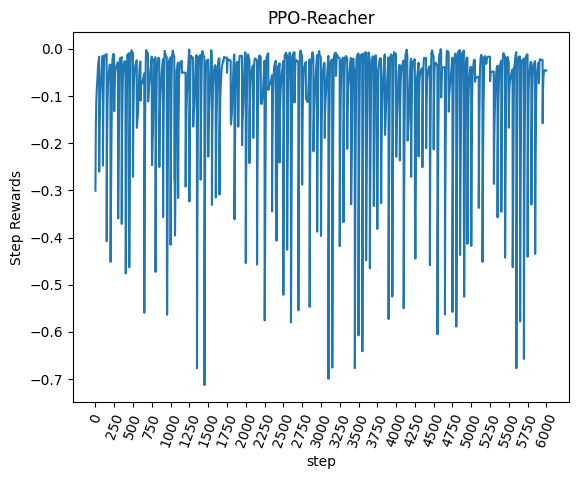

In [10]:
plt.plot(np.array(rewards_production))
plt.xlabel("step")
plt.ylabel("Step Rewards")
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.title("PPO-Reacher")
plt.show()

### Prob CUSUM

In [11]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [12]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)


delay = 4000
false_alarms = 0

for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

Drift Detected at: 1 with value: -0.26464322285311237
False Positives: 1, Delay: 4000


In [13]:
# Environment Drift Detection with CUSUM
env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000


for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  episode_deque.append(val)
  val_avg = np.mean(episode_deque)
  p_value, drift_detected = drift_detector.predict_next(val_avg, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val_avg}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

Drift Detected at: 0 with value: -0.08212105446741971
Drift Detected at: 1103 with value: -0.10626749586707693
Drift Detected at: 1122 with value: -0.10714452361414344
Drift Detected at: 1135 with value: -0.10843028380978989
Drift Detected at: 1160 with value: -0.08629824195032569
Drift Detected at: 3631 with value: -0.11989369563262145
False Positives: 5, Delay: 631


### Page-Hinkley

In [14]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 1063, input value: -1.9257465070540178
Change detected at index 2261, input value: -1.5462953834567212
Change detected at index 2418, input value: -1.1368038294938214
Change detected at index 3156, input value: -2.796424101701844
False Alarms: 3, Delay: 156


In [15]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 348, input value: -0.7995327419224418
Change detected at index 1013, input value: -0.8764864256373337
Change detected at index 1103, input value: -2.3273716894729763
Change detected at index 1481, input value: -1.3176070051989655
Change detected at index 2284, input value: -0.7011647038092373
Change detected at index 2420, input value: -3.2231680866107766
Change detected at index 3169, input value: -2.616917699906998
False Alarms: 6, Delay: 169


### ADWIN

In [16]:
adwin = drift.ADWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 351, input value: -1.6942602319682212
Change detected at index 2559, input value: -0.848239520721611
False Alarms: 2, Delay: 4000


In [17]:
adwin = drift.ADWIN()

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 383, input value: -0.27037299507778867
Change detected at index 511, input value: -0.27654324521392437
Change detected at index 831, input value: -0.39383803642147797
Change detected at index 991, input value: -0.7649299150180483
Change detected at index 1119, input value: -1.7893678322297668
Change detected at index 1247, input value: -0.39563509986014794
Change detected at index 1407, input value: -0.21516367766152175
Change detected at index 1535, input value: -1.0998743003082967
Change detected at index 2303, input value: -0.2564414385128542
Change detected at index 2431, input value: -2.3602023533157843
Change detected at index 2495, input value: -1.0268072069884784
Change detected at index 3167, input value: -1.9515645152087597
False Alarms: 11, Delay: 167


### KSWIN

In [18]:
kswin = drift.KSWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

False Alarms: 0, Delay: 4000


In [19]:
kswin = drift.KSWIN()

env0_steps = 4000

episode_length = 200

episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 99, input value: -0.2940954194695707
Change detected at index 499, input value: -0.6134811333449938
Change detected at index 599, input value: -0.17586882255754724
Change detected at index 999, input value: -0.3871607903543967
Change detected at index 1099, input value: -1.518031725046025
Change detected at index 1499, input value: -0.6402969982112843
Change detected at index 2399, input value: -0.489327496434519
Change detected at index 2499, input value: -0.695770073175513
Change detected at index 2600, input value: -1.1200297021417915
Change detected at index 3016, input value: -0.14211937359790608
False Alarms: 9, Delay: 16
